## 进行时间切分实验

In [1]:
# tensorflow GPU的设置
import tensorflow as tf 

# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

print(tf.__version__)

2.4.1


In [2]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from collections import Counter

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
# 加载数据 为平衡数据量，将2018年3月之前的数据和2017年的数据合并
def judge_1(time):
    time = time[:7].replace('-', '')
    if time <= '201803':
        return True
    else:
        return False

def judge_2(time):
    time = time[:7].replace('-', '')
    if time > '201803':
        return True
    else:
        return False

name2label = {'trojan':0, 'virus':1, 'worm':2, 'backdoor':3}
data_csv = pd.read_csv('../../csv/dataset_handled.csv')
data_2017 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2017']
data_2018 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2018']
data_2019 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2019']
    
data_2018_1 = data_2018[data_2018['first_seen'].apply(judge_1)]
data_2018_2 = data_2018[data_2018['first_seen'].apply(judge_2)]

data_train = data_2017.append(data_2018_１)
data_test_1 = data_2018_2
data_test_2 = data_2019

print("划分数据集后的数据统计:")
print(data_train.shape, data_test_1.shape, data_test_2.shape)
print(Counter(data_train.label))
print(Counter(data_test_1.label))
print(Counter(data_test_2.label))

data_test_1.to_csv("data_test_1.csv", index=0)
data_test_2.to_csv("data_test_2.csv", index=0)

# 对测试集进行下采样
data_train = data_train.sample(frac=1, random_state=1).reset_index(drop=True)
data_test_1 = data_test_1.sample(frac=0.73, random_state=1).reset_index(drop=True)
data_test_2 = data_test_2.sample(frac=0.54, random_state=1).reset_index(drop=True)

print("采样后的数据统计：")
print(data_train.shape, data_test_1.shape, data_test_2.shape)
print(Counter(data_train['label']), Counter(data_test_１['label']), Counter(data_test_2['label']), Counter(data_csv['label']))

划分数据集后的数据统计:
(6929, 9) (2668, 9) (3878, 9)
Counter({'worm': 1900, 'virus': 1865, 'trojan': 1783, 'backdoor': 1381})
Counter({'trojan': 817, 'virus': 735, 'worm': 559, 'backdoor': 557})
Counter({'trojan': 1000, 'virus': 1000, 'worm': 1000, 'backdoor': 878})
采样后的数据统计：
(6929, 9) (1948, 9) (2094, 9)
Counter({'worm': 1900, 'virus': 1865, 'trojan': 1783, 'backdoor': 1381}) Counter({'trojan': 589, 'virus': 541, 'worm': 415, 'backdoor': 403}) Counter({'trojan': 553, 'virus': 538, 'worm': 523, 'backdoor': 480}) Counter({'trojan': 3600, 'virus': 3600, 'worm': 3459, 'backdoor': 2816})


In [4]:
from utils import *
data_path_1, labels_1 = path_loader(data_train)
data_path_2, labels_2 = path_loader(data_test_1)
data_path_3, labels_3 = path_loader(data_test_2)

In [5]:
# 加载数据并进行训练
from tensorflow import keras
from tensorflow.keras import layers, optimizers, Sequential, metrics
from tensorflow.keras import Input, Model, regularizers
from malconv import get_malconv


batch_size = 128
db_train = tf.data.Dataset.from_generator(train_data_generator, args=[data_path_1, labels_1, 'train'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
db_train = db_train.batch(batch_size).repeat(9)

db_val = tf.data.Dataset.from_generator(train_data_generator, args=[data_path_1, labels_1, 'val'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
db_val = db_val.batch(batch_size).repeat(8)

model = get_malconv()
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=[keras.metrics.CategoricalAccuracy()])

history = model.fit(db_train,
                    epochs=7,
                    steps_per_epoch=46,
                    validation_data=db_val,
                    validation_steps=7)

Epoch 1/7
46/46 [==============================] - 476s 10s/step - loss: 1.8784 - categorical_accuracy: 0.6391 - val_loss: 0.9125 - val_categorical_accuracy: 0.9286
Epoch 2/7
46/46 [==============================] - 437s 10s/step - loss: 0.7874 - categorical_accuracy: 0.9309 - val_loss: 0.4888 - val_categorical_accuracy: 0.9754
Epoch 3/7
46/46 [==============================] - 425s 9s/step - loss: 0.4558 - categorical_accuracy: 0.9716 - val_loss: 0.3159 - val_categorical_accuracy: 0.9922
Epoch 4/7
46/46 [==============================] - 427s 9s/step - loss: 0.3092 - categorical_accuracy: 0.9845 - val_loss: 0.2257 - val_categorical_accuracy: 0.9978
Epoch 5/7
46/46 [==============================] - 436s 9s/step - loss: 0.2267 - categorical_accuracy: 0.9937 - val_loss: 0.1794 - val_categorical_accuracy: 0.9978
Epoch 6/7
46/46 [==============================] - 498s 11s/step - loss: 0.1778 - categorical_accuracy: 0.9975 - val_loss: 0.1515 - val_categorical_accuracy: 0.9978
Epoch 7/7
46/

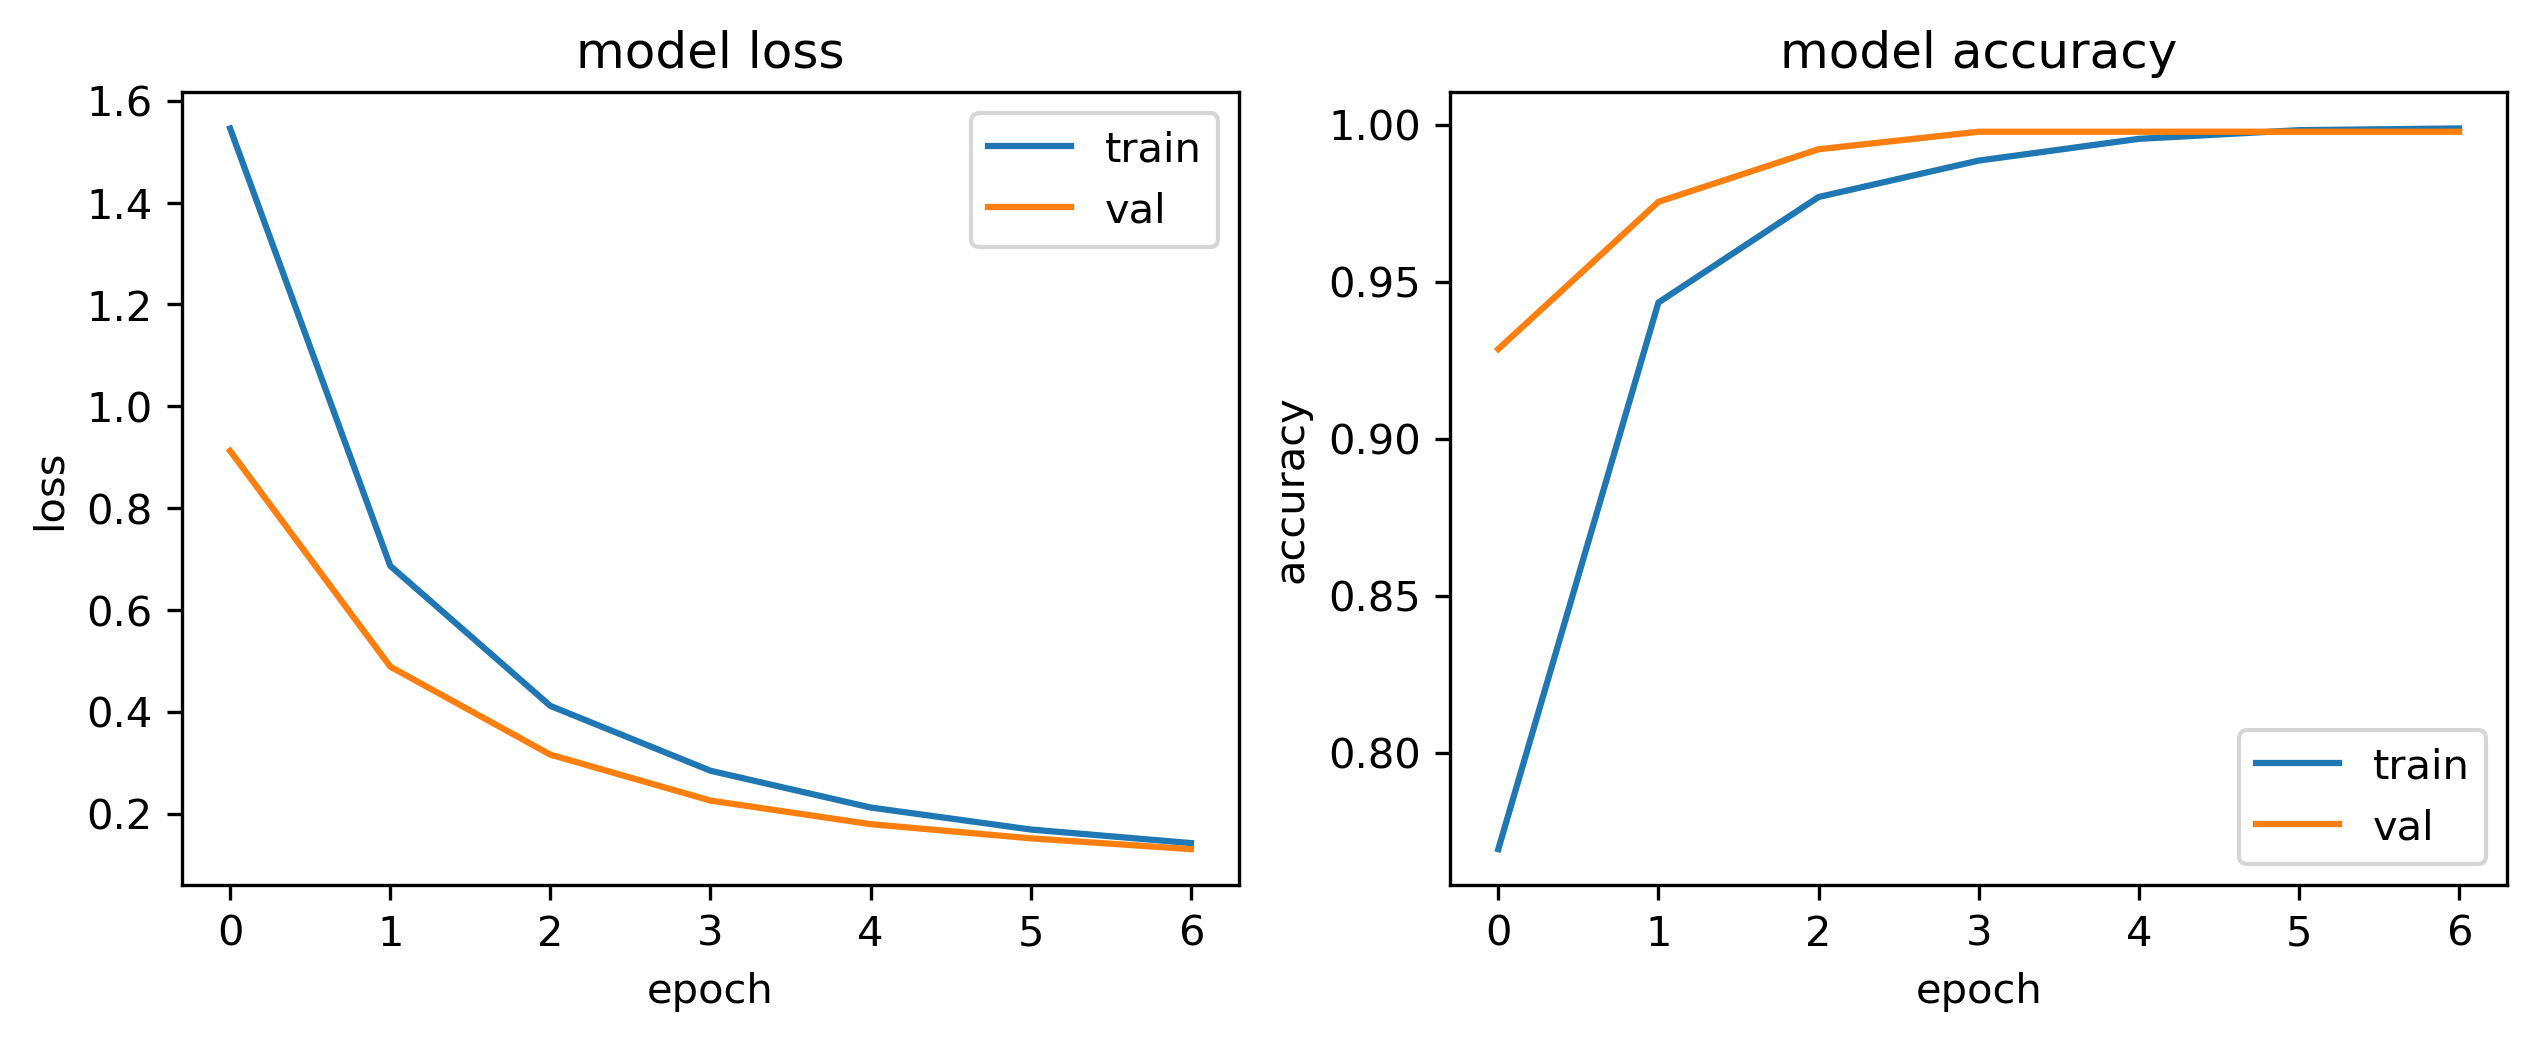

In [6]:
 # 绘制loss和acc曲线
def PlotLoss(model_name, history):
    
    p1 = plt.figure(figsize=(10, 3.5),dpi=300)
    ax1 = p1.add_subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train","val"],loc="upper right")

    ax2 = p1.add_subplot(1,2,2)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train","val"],loc="lower right")
    plt.savefig("./figures/" + model_name + '.png')

PlotLoss('malconv_split', history)

In [7]:
# 进行模型保存
model.save('../model/malconv_split.h5')

In [8]:
# 测试数据
from sklearn.metrics import classification_report
from tensorflow import keras
model = keras.models.load_model('../model/malconv_split.h5')
# 批量预测数据
batch_size = 100
for idx in range(0, len(data_path_2), batch_size):
    code_tmp, label_tmp = test_data_loader(data_path_2[idx:idx+batch_size], labels_2[idx:idx+batch_size])
    y_pred_tmp = model.predict(code_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_true_tmp = np.argmax(label_tmp, axis=1)
    y_pred = y_pred_tmp if idx == 0 else np.concatenate((y_pred, y_pred_tmp), axis = 0)
    y_true = y_true_tmp if idx == 0 else np.concatenate((y_true, y_true_tmp), axis = 0)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

100%|██████████| 48/48 [00:00<00:00, 54.71it/s]
              precision    recall  f1-score   support

        worm     0.8155    0.9983    0.8977       589
    backdoor     0.9818    0.9963    0.9890       541
       virus     0.9857    0.8313    0.9020       415
      trojan     0.9878    0.8040    0.8865       403

    accuracy                         0.9220      1948
   macro avg     0.9427    0.9075    0.9188      1948
weighted avg     0.9336    0.9220    0.9216      1948



In [9]:
# 2019年测试集
# 批量预测数据
batch_size = 100
for idx in range(0, len(data_path_3), batch_size):
    code_tmp, label_tmp = test_data_loader(data_path_3[idx:idx+batch_size], labels_3[idx:idx+batch_size])
    y_pred_tmp = model.predict(code_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_true_tmp = np.argmax(label_tmp, axis=1)
    y_pred = y_pred_tmp if idx == 0 else np.concatenate((y_pred, y_pred_tmp), axis = 0)
    y_true = y_true_tmp if idx == 0 else np.concatenate((y_true, y_true_tmp), axis = 0)

target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

100%|██████████| 94/94 [00:01<00:00, 48.92it/s]
              precision    recall  f1-score   support

        worm     0.8300    0.9801    0.8988       553
    backdoor     0.9810    0.9591    0.9699       538
       virus     0.9614    0.9044    0.9320       523
      trojan     0.9858    0.8688    0.9236       480

    accuracy                         0.9303      2094
   macro avg     0.9396    0.9281    0.9311      2094
weighted avg     0.9373    0.9303    0.9311      2094



In [10]:
# 训练数据
from sklearn.metrics import classification_report
from tensorflow import keras
model = keras.models.load_model('../model/malconv_split.h5')

# 批量预测数据
batch_size = 100
for idx in range(0, len(data_path_1), batch_size):
    code_tmp, label_tmp = test_data_loader(data_path_1[idx:idx+batch_size], labels_1[idx:idx+batch_size])
    y_pred_tmp = model.predict(code_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_true_tmp = np.argmax(label_tmp, axis=1)
    y_pred = y_pred_tmp if idx == 0 else np.concatenate((y_pred, y_pred_tmp), axis = 0)
    y_true = y_true_tmp if idx == 0 else np.concatenate((y_true, y_true_tmp), axis = 0)

# codes_train, labels_train = train_data_loader(data_path_１, labels_１, 'train')
# y_pred = model.predict(codes_train)
# y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(labels_train, axis=1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=6))

100%|██████████| 29/29 [00:01<00:00, 26.30it/s]
              precision    recall  f1-score   support

        worm   0.998320  1.000000  0.999159      1783
    backdoor   0.998928  0.999464  0.999196      1865
       virus   1.000000  0.997895  0.998946      1900
      trojan   1.000000  1.000000  1.000000      1381

    accuracy                       0.999278      6929
   macro avg   0.999312  0.999340  0.999325      6929
weighted avg   0.999279  0.999278  0.999278      6929

